In [1]:
import sys
sys.path.insert(0, '../libraries')


from dataloader import load_dataset,create_patch_dataset_return_shifts
from utils import safe_mkdir,upsampling_without_aggregation_all_imageset,upsampling_mask_all_imageset,registration_imageset_against_best_image_without_union_mask
import numpy as np
import pandas as pd
from skimage.feature import register_translation
import os
import glob
from collections import defaultdict
%reload_ext autoreload
%autoreload 2



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
dir_pickles_probav='./pickles/'
out_dataset='./testset'
safe_mkdir(out_dataset)
#base_dir='./probav_data'


# Load testset NIR

In [3]:
band='NIR'
input_images_LR_test = np.load(os.path.join(dir_pickles_probav, 'LR_test_{0}.npy'.format(band)))
mask_LR_test = np.load(os.path.join(dir_pickles_probav, 'LR_mask_{0}_test.npy'.format(band)))

    

### Have a look at a LR image

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=[5,5])
plt.imshow((input_images_LR_test[0][0]).squeeze(), cmap = 'gray', interpolation = 'none')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

<Figure size 500x500 with 1 Axes>

# Pre-processing, hidden regions, bad intensity values

In [5]:
#transform in a list of numpy
input_images_LR_test=np.array([np.array(x) for x in input_images_LR_test])
mask_LR_test=np.array([np.array(x) for x in mask_LR_test])

### The images are supposed to be over 14 bits, but there many images with values > 2^14 -1
### Removing all images in which we find at least one pixel > 60000.

In [6]:
#Find the indexes to remove with very high pixels
images_to_remove=[[i,j] for i,x in enumerate(input_images_LR_test) for j,z in enumerate(x) if (z>60000).any() ]
#generate dictionary with as key the index of the imageset and as value a list of indexes correpsonding to images
# to remove of that specific imageset
from collections import defaultdict
d=defaultdict(list)
for i in images_to_remove:
    d[i[0]].append(i[1])
    

In [7]:
for i in d.keys():
    input_images_LR_test[i]\
    =np.delete(input_images_LR_test[i],d[i],axis=0)
    
    mask_LR_test[i]\
    =np.delete(mask_LR_test[i],d[i],axis=0)


### How many imagesets have less than 9 images , now that we have removed the bad registered images

In [8]:
[x.shape for x in input_images_LR_test if x.shape[0]<9]

[]

### Remove the imagesets with less than 9 images

In [9]:
indexes=[i for i,x in enumerate(input_images_LR_test) if np.array(x).shape[0]<9]

#LR
input_images_LR_test=np.delete(input_images_LR_test,indexes,axis=0)
mask_LR_test=np.delete(mask_LR_test,indexes,axis=0)

## Upsampling

### Upsampling  test set


The goal is to upsample all LR images of each imageset loaded from pickles

In [10]:
input_images_LR_test_upsample=upsampling_without_aggregation_all_imageset(input_images_LR_test,scale=3)

### Upsampling masks corresponding to test set

In [11]:
mask_LR_test_upsample=upsampling_mask_all_imageset(mask_LR_test,scale=3)

### Register imageset and mask

In [12]:
input_images_LR_test_upsample_registered,\
mask_LR_test_upsample_registered,\
shifts_test,\
new_index_orders_test=registration_imageset_against_best_image_without_union_mask(input_images_LR_test_upsample,
                                                mask_LR_test_upsample,
                                                1)





../libraries/utils.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  imageset_training_registered[j_index]=corrected_image


In [13]:
shifts_test

[array([[0., 0.],
        [0., 3.],
        [0., 0.],
        [0., 0.],
        [0., 3.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 3.],
        [0., 0.],
        [0., 0.],
        [0., 0.]]), array([[ 0.,  0.],
        [ 1.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 1.,  1.],
        [ 0.,  0.],
        [-1.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 1.,  0.],
        [ 0.,  0.],
        [ 1.,  0.]]), array([[  0.,   0.],
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   1.],
        [  0.,   0.],
        [  0.,   0.],
        [-51., 178.],
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.]]), array([[0., 0.],
        [0., 0.],
        [0., 3.],
        [0., 3.],
     

In [14]:
#transform in a list of numpy
input_images_LR_test_upsample=np.array([np.array(x) for x in input_images_LR_test_upsample])
mask_LR_test_upsample=np.array([np.array(x) for x in mask_LR_test_upsample])

In [15]:
#Reorder the upsampled and not registered testset the way the upsdampled and registered testset has been ordered
#so that it matched the ordering of the shifts we computed during registration

input_images_LR_test_upsample=[imageset[new_index_orders_test[i]] for i,imageset in enumerate(input_images_LR_test_upsample)]
mask_LR_test_upsample=[imageset[new_index_orders_test[i]] for i,imageset in enumerate(mask_LR_test_upsample)]


In [16]:
#Find the indexes to remove considering we want to keep up to 4 pixel shift.
images_to_remove=[[i,j,z] for i,x in enumerate(shifts_test) for j,z in enumerate(x) if (np.abs(z)>4).any() ]
#generate dictionary with as key the index of the imageset and as value a list of indexes correpsonding to images
# to remove of that specific imageset
from collections import defaultdict

d=defaultdict(list)

for i in images_to_remove:
    d[i[0]].append(i[1])
    

In [17]:
d

defaultdict(list,
            {2: [7],
             6: [11],
             12: [4, 11, 14, 17],
             13: [5, 13],
             24: [9],
             36: [1],
             46: [7],
             55: [7],
             57: [11],
             67: [3],
             70: [5],
             77: [4],
             78: [14],
             90: [7],
             99: [5],
             110: [18],
             125: [1],
             137: [11],
             139: [4, 13]})

### Remove the images from LR images

In [18]:
for i in d.keys():
    input_images_LR_test_upsample[i]\
    =np.delete(input_images_LR_test_upsample[i],d[i],axis=0)
    
    mask_LR_test_upsample[i]\
    =np.delete(mask_LR_test_upsample[i],d[i],axis=0)


### How many imagesets have less than 9 images , now that we have removed the bad registered images

In [19]:
[x.shape for x in input_images_LR_test_upsample if x.shape[0]<9]

[]

In [20]:
len([x.shape for x in input_images_LR_test_upsample if x.shape[0]<9])

0

### Fortunately we have more than 9 images per imageset!!!!!!!!!!!!!!
#### Our network works with a minimum of 9 images and here we need all imagesets, to submit to probav challenge website

In [21]:
# Update also shifts array

for i in d.keys():
    shifts_test[i]\
    =np.delete(shifts_test[i],d[i],axis=0)

#shifts_test=np.delete(shifts_test,indexes,axis=0) NOT NEEDED

In [22]:
[[i,j,z] for i,x in enumerate(shifts_test) for j,z in enumerate(x) if (np.abs(z)>=0).any() ]

[[0, 0, array([0., 0.])],
 [0, 1, array([0., 3.])],
 [0, 2, array([0., 0.])],
 [0, 3, array([0., 0.])],
 [0, 4, array([0., 3.])],
 [0, 5, array([0., 0.])],
 [0, 6, array([0., 0.])],
 [0, 7, array([0., 0.])],
 [0, 8, array([0., 0.])],
 [0, 9, array([0., 0.])],
 [0, 10, array([0., 0.])],
 [0, 11, array([0., 3.])],
 [0, 12, array([0., 0.])],
 [0, 13, array([0., 0.])],
 [0, 14, array([0., 0.])],
 [1, 0, array([0., 0.])],
 [1, 1, array([1., 0.])],
 [1, 2, array([0., 0.])],
 [1, 3, array([0., 0.])],
 [1, 4, array([1., 1.])],
 [1, 5, array([0., 0.])],
 [1, 6, array([-1.,  0.])],
 [1, 7, array([0., 0.])],
 [1, 8, array([0., 0.])],
 [1, 9, array([0., 0.])],
 [1, 10, array([0., 0.])],
 [1, 11, array([0., 0.])],
 [1, 12, array([0., 0.])],
 [1, 13, array([1., 0.])],
 [1, 14, array([0., 0.])],
 [1, 15, array([1., 0.])],
 [2, 0, array([0., 0.])],
 [2, 1, array([0., 0.])],
 [2, 2, array([0., 0.])],
 [2, 3, array([0., 0.])],
 [2, 4, array([0., 1.])],
 [2, 5, array([0., 0.])],
 [2, 6, array([0., 0.])],

### Statistics about the shifts

In [23]:
len([[i,j,z] for i,x in enumerate(shifts_test) for j,z in enumerate(x) if (np.abs(z)==0).all() ])

1438

In [24]:
len([[i,j,z] for i,x in enumerate(shifts_test) for j,z in enumerate(x) if (np.abs(z)>=0).any() ])

2599

### Save the validation dataset

In [25]:
np.save(os.path.join(out_dataset,'dataset_{0}_LR_test.npy'.format(band)),input_images_LR_test_upsample,allow_pickle=True)
np.save(os.path.join(out_dataset,'dataset_{0}_mask_LR_test.npy'.format(band)),mask_LR_test_upsample,allow_pickle=True)
np.save(os.path.join(out_dataset,'shifts_test_{0}.npy'.format(band)),shifts_test,allow_pickle=True)


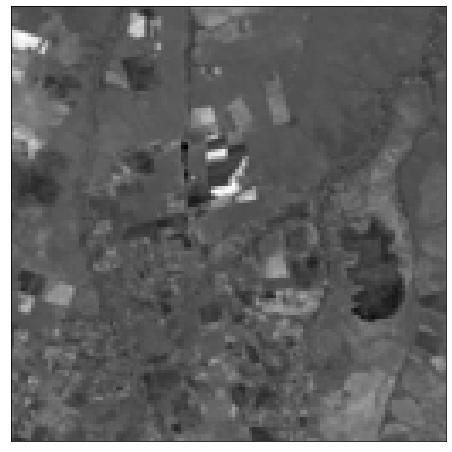

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=[8,8])
plt.imshow((input_images_LR_test[17][3]).squeeze(), cmap = 'gray', interpolation = 'none')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

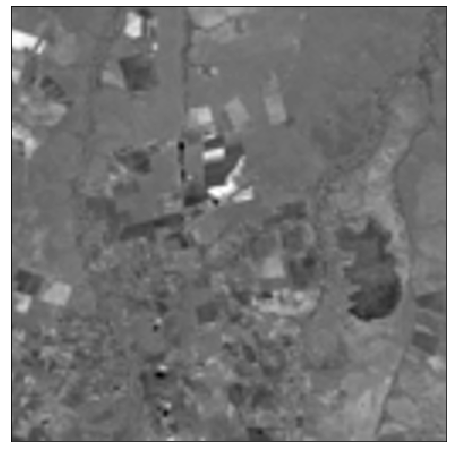

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=[8,8])
plt.imshow((input_images_LR_test_upsample[17][3]).squeeze(), cmap = 'gray', interpolation = 'none')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

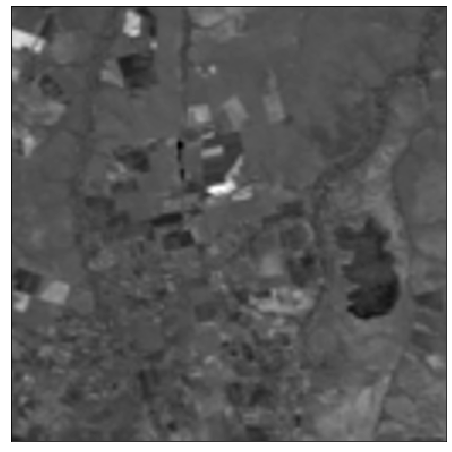

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=[8,8])
plt.imshow((input_images_LR_test_upsample[17][0]).squeeze(), cmap = 'gray', interpolation = 'none')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

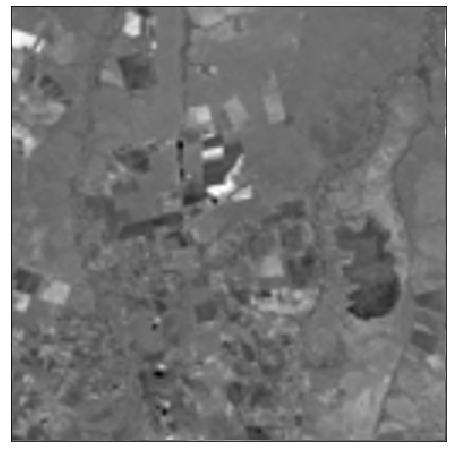

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=[8,8])
plt.imshow((input_images_LR_test_upsample_registered[17][3]).squeeze(), cmap = 'gray', interpolation = 'none')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

# Load testset RED

In [30]:
band='RED'
input_images_LR_test = np.load(os.path.join(dir_pickles_probav, 'LR_test_{0}.npy'.format(band)))
mask_LR_test = np.load(os.path.join(dir_pickles_probav, 'LR_mask_{0}_test.npy'.format(band)))

    

### Have a look at a LR image

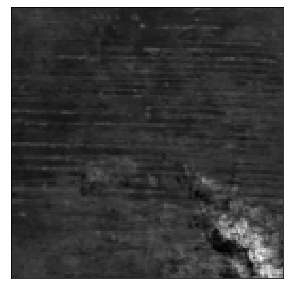

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=[5,5])
plt.imshow((input_images_LR_test[0][0]).squeeze(), cmap = 'gray', interpolation = 'none')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

# Pre-processing, hidden regions, bad intensity values

In [32]:
#transform in a list of numpy
input_images_LR_test=np.array([np.array(x) for x in input_images_LR_test])
mask_LR_test=np.array([np.array(x) for x in mask_LR_test])

### The images are supposed to be over 14 bits, but there many images with values > 2^14 -1
### Removing all images in which we find at least one pixel > 60000.

In [33]:
#Find the indexes to remove with very high pixels
images_to_remove=[[i,j] for i,x in enumerate(input_images_LR_test) for j,z in enumerate(x) if (z>60000).any() ]
#generate dictionary with as key the index of the imageset and as value a list of indexes correpsonding to images
# to remove of that specific imageset
from collections import defaultdict
d=defaultdict(list)
for i in images_to_remove:
    d[i[0]].append(i[1])
    

In [34]:
for i in d.keys():
    input_images_LR_test[i]\
    =np.delete(input_images_LR_test[i],d[i],axis=0)
    
    mask_LR_test[i]\
    =np.delete(mask_LR_test[i],d[i],axis=0)


### How many imagesets have less than 9 images , now that we have removed the bad registered images

In [35]:
[x.shape for x in input_images_LR_test if x.shape[0]<9]

[]

### Remove the imagesets with less than 9 images

In [36]:
indexes=[i for i,x in enumerate(input_images_LR_test) if np.array(x).shape[0]<9]

#LR
input_images_LR_test=np.delete(input_images_LR_test,indexes,axis=0)
mask_LR_test=np.delete(mask_LR_test,indexes,axis=0)

## Upsampling

### Upsampling  test set


The goal is to upsample all LR images of each imageset loaded from pickles

In [37]:
input_images_LR_test_upsample=upsampling_without_aggregation_all_imageset(input_images_LR_test,scale=3)

### Upsampling masks corresponding to test set

In [38]:
mask_LR_test_upsample=upsampling_mask_all_imageset(mask_LR_test,scale=3)

### Register imageset and mask

In [39]:
input_images_LR_test_upsample_registered,\
mask_LR_test_upsample_registered,\
shifts_test,\
new_index_orders_test=registration_imageset_against_best_image_without_union_mask(input_images_LR_test_upsample,
                                                mask_LR_test_upsample,
                                                1)





In [40]:
shifts_test

[array([[   0.,    0.],
        [  -1.,   -3.],
        [  -1.,   -2.],
        [  -1.,   -3.],
        [   0.,   -3.],
        [-115., -121.],
        [   0.,   -3.],
        [   0.,   -2.],
        [   0.,    0.],
        [   0.,   -2.],
        [   0.,   -2.],
        [   0.,   -3.],
        [   0.,   -3.],
        [   0.,   -2.],
        [   0.,   -2.],
        [   0.,   -2.],
        [   0.,   -2.],
        [   0.,   -3.]]), array([[ 0.,  0.],
        [-1.,  0.],
        [ 0.,  0.],
        [-1.,  0.],
        [ 0.,  0.],
        [-1.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [-1.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [-1.,  0.],
        [-1.,  0.],
        [-1.,  0.],
        [ 0.,  0.],
        [-4.,  1.],
        [ 0.,  0.],
        [-1., -1.],
        [ 0.,  0.],
        [-1.,  0.],
        [ 0.,  0.]]), array([[ 0.,  0.],
        [ 1.,  0.],
        [ 0.,  0.],
        [ 1.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  0.],
      

In [41]:
#transform in a list of numpy
input_images_LR_test_upsample=np.array([np.array(x) for x in input_images_LR_test_upsample])
mask_LR_test_upsample=np.array([np.array(x) for x in mask_LR_test_upsample])

In [42]:
#Reorder the upsampled and not registered testset the way the upsdampled and registered testset has been ordered
#so that it matched the ordering of the shifts we computed during registration

input_images_LR_test_upsample=[imageset[new_index_orders_test[i]] for i,imageset in enumerate(input_images_LR_test_upsample)]
mask_LR_test_upsample=[imageset[new_index_orders_test[i]] for i,imageset in enumerate(mask_LR_test_upsample)]


In [43]:
#Find the indexes to remove considering we want to keep up to 4 pixel shift.
images_to_remove=[[i,j,z] for i,x in enumerate(shifts_test) for j,z in enumerate(x) if (np.abs(z)>4).any() ]
#generate dictionary with as key the index of the imageset and as value a list of indexes correpsonding to images
# to remove of that specific imageset
from collections import defaultdict

d=defaultdict(list)

for i in images_to_remove:
    d[i[0]].append(i[1])
    

In [44]:
d

defaultdict(list,
            {0: [5],
             2: [11],
             15: [7],
             18: [7],
             20: [21],
             25: [9],
             27: [8],
             28: [5],
             32: [4],
             45: [20],
             47: [12, 14, 16],
             49: [4, 11, 14, 17],
             55: [11],
             57: [2, 4, 6, 8, 15],
             58: [18],
             62: [3],
             63: [7],
             64: [2, 9],
             79: [7, 9],
             83: [16],
             88: [6],
             99: [9],
             100: [4, 9, 13],
             106: [1],
             120: [5],
             133: [1],
             137: [5, 13],
             143: [12]})

### Remove the images from LR images

In [45]:
for i in d.keys():
    input_images_LR_test_upsample[i]\
    =np.delete(input_images_LR_test_upsample[i],d[i],axis=0)
    
    mask_LR_test_upsample[i]\
    =np.delete(mask_LR_test_upsample[i],d[i],axis=0)


### How many imagesets have less than 9 images , now that we have removed the bad registered images

In [46]:
[x.shape for x in input_images_LR_test_upsample if x.shape[0]<9]

[]

In [47]:
len([x.shape for x in input_images_LR_test_upsample if x.shape[0]<9])

0

### Fortunately we have more than 9 images per imageset!!!!!!!!!!!!!!
#### Our network works with a minimum of 9 images and here we need all imagesets, to submit to probav challenge website

In [48]:
# Update also shifts array

for i in d.keys():
    shifts_test[i]\
    =np.delete(shifts_test[i],d[i],axis=0)

#shifts_test=np.delete(shifts_test,indexes,axis=0) NOT NEEDED

In [49]:
[[i,j,z] for i,x in enumerate(shifts_test) for j,z in enumerate(x) if (np.abs(z)>=0).any() ]

[[0, 0, array([0., 0.])],
 [0, 1, array([-1., -3.])],
 [0, 2, array([-1., -2.])],
 [0, 3, array([-1., -3.])],
 [0, 4, array([ 0., -3.])],
 [0, 5, array([ 0., -3.])],
 [0, 6, array([ 0., -2.])],
 [0, 7, array([0., 0.])],
 [0, 8, array([ 0., -2.])],
 [0, 9, array([ 0., -2.])],
 [0, 10, array([ 0., -3.])],
 [0, 11, array([ 0., -3.])],
 [0, 12, array([ 0., -2.])],
 [0, 13, array([ 0., -2.])],
 [0, 14, array([ 0., -2.])],
 [0, 15, array([ 0., -2.])],
 [0, 16, array([ 0., -3.])],
 [1, 0, array([0., 0.])],
 [1, 1, array([-1.,  0.])],
 [1, 2, array([0., 0.])],
 [1, 3, array([-1.,  0.])],
 [1, 4, array([0., 0.])],
 [1, 5, array([-1.,  0.])],
 [1, 6, array([0., 0.])],
 [1, 7, array([0., 0.])],
 [1, 8, array([-1.,  0.])],
 [1, 9, array([0., 0.])],
 [1, 10, array([0., 0.])],
 [1, 11, array([-1.,  0.])],
 [1, 12, array([-1.,  0.])],
 [1, 13, array([-1.,  0.])],
 [1, 14, array([0., 0.])],
 [1, 15, array([-4.,  1.])],
 [1, 16, array([0., 0.])],
 [1, 17, array([-1., -1.])],
 [1, 18, array([0., 0.])],


### Statistics about the shifts

In [50]:
len([[i,j,z] for i,x in enumerate(shifts_test) for j,z in enumerate(x) if (np.abs(z)==0).all() ])

1503

In [51]:
len([[i,j,z] for i,x in enumerate(shifts_test) for j,z in enumerate(x) if (np.abs(z)>=0).any() ])

2606

### Save the validation dataset

In [52]:
np.save(os.path.join(out_dataset,'dataset_{0}_LR_test.npy'.format(band)),input_images_LR_test_upsample,allow_pickle=True)
np.save(os.path.join(out_dataset,'dataset_{0}_mask_LR_test.npy'.format(band)),mask_LR_test_upsample,allow_pickle=True)
np.save(os.path.join(out_dataset,'shifts_test_{0}.npy'.format(band)),shifts_test,allow_pickle=True)


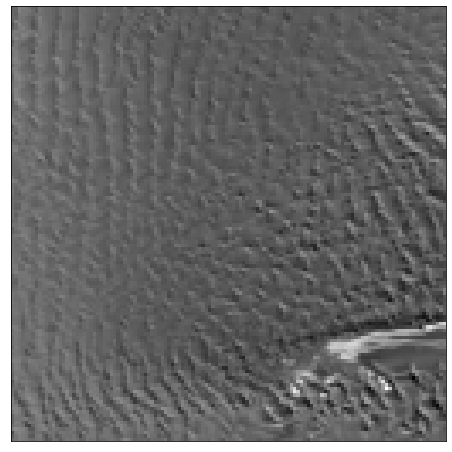

In [53]:
import matplotlib.pyplot as plt
plt.figure(figsize=[8,8])
plt.imshow((input_images_LR_test[17][3]).squeeze(), cmap = 'gray', interpolation = 'none')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

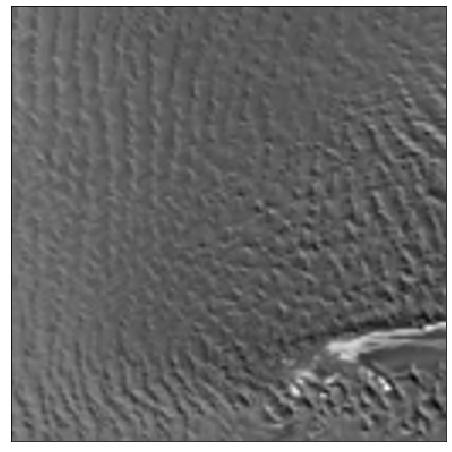

In [54]:
import matplotlib.pyplot as plt
plt.figure(figsize=[8,8])
plt.imshow((input_images_LR_test_upsample[17][3]).squeeze(), cmap = 'gray', interpolation = 'none')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

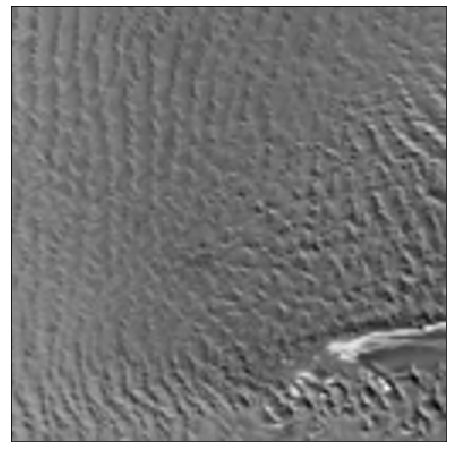

In [55]:
import matplotlib.pyplot as plt
plt.figure(figsize=[8,8])
plt.imshow((input_images_LR_test_upsample[17][0]).squeeze(), cmap = 'gray', interpolation = 'none')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

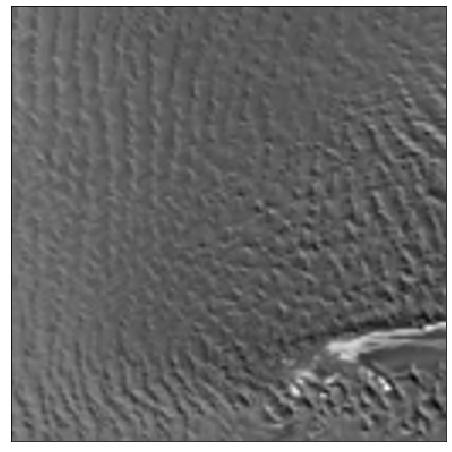

In [56]:
import matplotlib.pyplot as plt
plt.figure(figsize=[8,8])
plt.imshow((input_images_LR_test_upsample_registered[17][3]).squeeze(), cmap = 'gray', interpolation = 'none')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()